In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## for correlation matrices
import seaborn as sns
%matplotlib inline
## for linear models
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report



In [2]:
# Must download from http://web.stanford.edu/group/deepsolar/deepsolar_tract.csv and delete the first ","
df = pd.read_csv("deepsolar_tract.csv", encoding = "utf-8")


In [3]:
# Remove all deepsolar inputs

df = df.drop(columns=['solar_system_count'], axis = 1)
df = df.drop(columns=['total_panel_area'], axis = 1)
df = df.drop(columns=['solar_panel_area_per_capita'], axis =1)

df = df.drop(columns=['solar_panel_area_divided_by_area'], axis = 1)
df = df.drop(columns=['tile_count_residential'], axis = 1)
df = df.drop(columns=['tile_count_nonresidential'], axis = 1)
df = df.drop(columns=['solar_system_count_residential'], axis =1)

df = df.drop(columns=['solar_system_count_nonresidential'], axis = 1)
df = df.drop(columns=['total_panel_area_residential'], axis = 1)
df = df.drop(columns=['total_panel_area_nonresidential'], axis = 1)
df = df.drop(columns=['number_of_solar_system_per_household'], axis =1)

# Remove all unique identifiers, objects, and booleans
df = df.drop(columns=['county',
                      'state',
                     'electricity_price_transportation',
                     'voting_2016_dem_win',
                     'voting_2012_dem_win',
                     'fips'])



In [4]:
# tilesLargerThanZero = range(1,4469)
df['has_tiles'] = (df.tile_count > 0).mul(1)

In [5]:
df = df.drop('tile_count', axis = 1)

In [6]:
df = df.dropna()

# Balance

In [7]:
# Define X and y
y = df['has_tiles']
X = df.drop('has_tiles', axis = 1)
# Split the data into training and test sets
# from sklearn.model_selection import train_test_split

#ADD STRATIFIED HERE

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
#print(y_train.value_counts(),'\n\n', y_test.value_counts())

# SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

1    31209
0    31209
Name: has_tiles, dtype: int64 

 1    10392
0     3133
Name: has_tiles, dtype: int64


# Scale

In [8]:
# col_names = list(df.columns)
# scaler = preprocessing.MinMaxScaler()
# Xtrain = scaler.fit_transform(X_train)
# Xtest = scaler.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train.fillna(0))


StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
sel_ = SelectFromModel(LogisticRegression(C=.001, solver = 'saga', penalty='l1'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.001, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None, solver='saga',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [11]:
remaining_feats = X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]
remaining_feats

Index(['average_household_income', 'education_bachelor',
       'education_population', 'heating_fuel_gas', 'population',
       'population_density', 'race_two_more',
       'education_high_school_graduate_rate', 'education_bachelor_rate',
       'education_master_rate', 'education_professional_school_rate',
       'heating_fuel_coal_coke_rate', 'heating_fuel_other_rate',
       'electricity_price_industrial', 'electricity_consume_total',
       'housing_unit_median_gross_rent', 'lon', 'heating_design_temperature',
       'relative_humidity', 'atmospheric_pressure', 'age_more_than_85_rate',
       'occupation_construction_rate', 'occupation_administrative_rate',
       'occupation_arts_rate', 'occupation_agriculture_rate',
       'occupancy_vacant_rate', 'mortgage_with_rate',
       'travel_time_less_than_10_rate', 'travel_time_10_19_rate',
       'travel_time_30_39_rate', 'travel_time_40_59_rate',
       'travel_time_average', 'incentive_count_nonresidential',
       'incentive_resid

C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


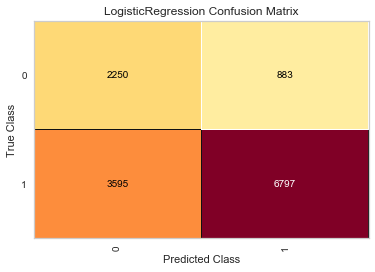

In [14]:
clf = LogisticRegression(C=.001, solver = 'saga', penalty='l1')
clf.fit(X_train, y_train)
cm = ConfusionMatrix(clf)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

In [26]:
cm.score(X_test, y_test)

0.668909426987061

In [16]:
TP = 6797
TN = 2250
FN = 3595
FP = 883

precision = TP/(TP+FP)
recall = TP/(TP+FN)
print(precision)
print(recall)

0.8850260416666667
0.6540608160123171


In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.72      0.50      3133
           1       0.89      0.65      0.75     10392

    accuracy                           0.67     13525
   macro avg       0.63      0.69      0.63     13525
weighted avg       0.77      0.67      0.69     13525

